In [1]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *


#Handy for debugging
import gc
import time
import warnings
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

## Keras for deep learning
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras import optimizers

## Performance measures
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/pasha00786/genpact_hackathon/master/input/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/pasha00786/genpact_hackathon/master/input/test.csv')
train['Split'] = 'Train'
test['Split'] = 'Test'
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,Split
0,1028232,146,55,1885,158.11,159.11,0,0,Test
1,1127204,146,55,1993,160.11,159.11,0,0,Test
2,1212707,146,55,2539,157.14,159.14,0,0,Test
3,1082698,146,55,2631,162.02,162.02,0,0,Test
4,1400926,146,55,1248,163.93,163.93,0,0,Test


In [3]:
t_len = len(train) # Get number of training examples
df = pd.concat([train,test],axis=0) # Join train and test
df.tail() # Get an overview of the data

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week
32568,Test,484.09,61,482.09,0,0,1250239,1543,NaN,155
32569,Test,483.09,61,483.09,0,0,1039516,2304,NaN,155
32570,Test,323.07,61,322.07,0,0,1158107,2664,NaN,155
32571,Test,323.07,61,322.07,0,0,1444235,2569,NaN,155
32572,Test,276.45,61,276.45,0,0,1291286,2490,NaN,155


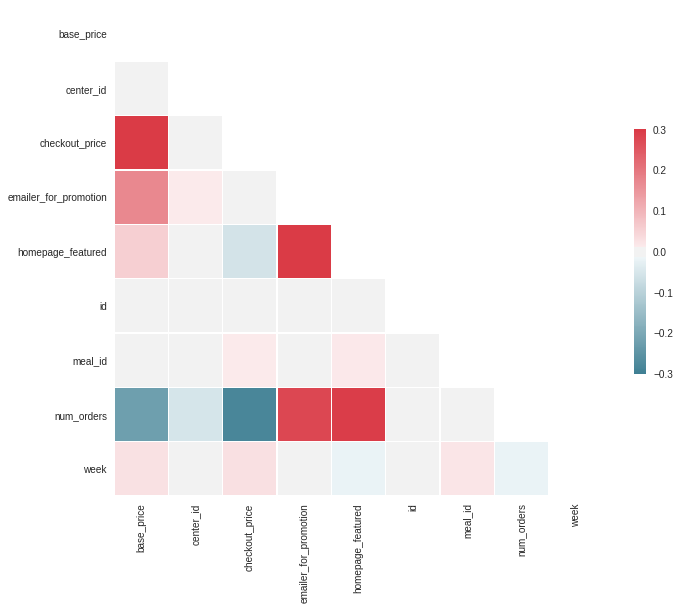

In [4]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

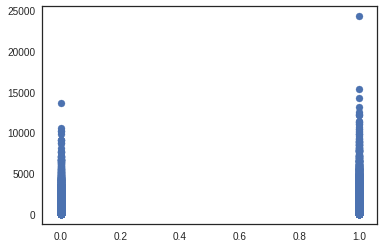

In [5]:
%matplotlib inline
plt.scatter(df['homepage_featured'], df['num_orders'])
plt.show()

In [6]:
df.loc[df['num_orders'] >15000]

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week
14050,Train,311.43,43,159.08,1,1,1452474,2290,24299.0,5
19700,Train,311.43,43,159.08,1,1,1300512,2290,15336.0,7


In [7]:
df.isnull().sum()

Split                        0
base_price                   0
center_id                    0
checkout_price               0
emailer_for_promotion        0
homepage_featured            0
id                           0
meal_id                      0
num_orders               32573
week                         0
dtype: int64

In [0]:
df.fillna(0, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 32572
Data columns (total 10 columns):
Split                    489121 non-null object
base_price               489121 non-null float64
center_id                489121 non-null int64
checkout_price           489121 non-null float64
emailer_for_promotion    489121 non-null int64
homepage_featured        489121 non-null int64
id                       489121 non-null int64
meal_id                  489121 non-null int64
num_orders               489121 non-null float64
week                     489121 non-null int64
dtypes: float64(3), int64(6), object(1)
memory usage: 61.0+ MB


In [10]:
# Get dataframe with averages per meal and centre
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['meal_id','center_id'])['num_orders'].median()}).reset_index()
medians.head()

,meal_id,center_id,Median Sales
0,1062,10,931.0
1,1062,11,798.0
2,1062,13,1067.0
3,1062,14,284.0
4,1062,17,366.0


In [0]:
# Merge by meal_id and center_id
df = df.merge(medians, how = 'outer', on = ['meal_id','center_id'])

In [0]:
# Fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 

# Create a key for easy access

df['Key'] = df['meal_id'].map(str)+df['center_id'].map(str)

In [13]:
df.head()

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,Median Sales,Key
0,Train,152.29,55,136.83,0,0,1379560,1885,177.0,1,215.0,188555
1,Train,152.29,55,135.83,0,0,1018704,1885,323.0,2,215.0,188555
2,Train,133.92,55,132.92,0,0,1196273,1885,96.0,3,215.0,188555
3,Train,134.86,55,135.86,0,0,1116527,1885,163.0,4,215.0,188555
4,Train,147.50,55,146.50,0,0,1343872,1885,215.0,5,215.0,188555


In [14]:
df['WeekLagged'] = df['week'] - 1
df.head()

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,Median Sales,Key,WeekLagged
0,Train,152.29,55,136.83,0,0,1379560,1885,177.0,1,215.0,188555,0
1,Train,152.29,55,135.83,0,0,1018704,1885,323.0,2,215.0,188555,1
2,Train,133.92,55,132.92,0,0,1196273,1885,96.0,3,215.0,188555,2
3,Train,134.86,55,135.86,0,0,1116527,1885,163.0,4,215.0,188555,3
4,Train,147.50,55,146.50,0,0,1343872,1885,215.0,5,215.0,188555,4


In [0]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['meal_id', 'center_id','week'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

In [16]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_week = row["WeekLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['week']== lag_week) & (last['num_orders']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['num_orders'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [17]:
sorted_df[['meal_id', 'center_id','week','LaggedSales','num_orders','Median Sales']].head()

,meal_id,center_id,week,LaggedSales,num_orders,Median Sales
0,1062,10,1,931.0,865.0,931.0
1,1062,10,2,865.0,782.0,931.0
2,1062,10,3,782.0,851.0,931.0
3,1062,10,4,851.0,1202.0,931.0
4,1062,10,5,1202.0,958.0,931.0


In [0]:
# Merge by store and department
df = df.merge(sorted_df[['center_id', 'meal_id','week','LaggedSales','LaggedAvailable']], how = 'inner', on = ['meal_id', 'center_id','week'])

In [19]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['center_id', 'meal_id','week','LaggedSales','num_orders','Median Sales']].head()

,center_id,meal_id,week,LaggedSales,num_orders,Median Sales
0,55,1885,1,215.0,177.0,215.0
1,55,1885,2,177.0,323.0,215.0
2,55,1885,3,323.0,96.0,215.0
3,55,1885,4,96.0,163.0,215.0
4,55,1885,5,163.0,215.0,215.0


In [0]:
df['Difference'] = df['Median Sales'] - df['num_orders']

In [21]:
df.head()

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,Median Sales,Key,WeekLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,Train,152.29,55,136.83,0,0,1379560,1885,177.0,1,215.0,188555,0,215.0,0.0,0.0,38.0
1,Train,152.29,55,135.83,0,0,1018704,1885,323.0,2,215.0,188555,1,177.0,1.0,38.0,-108.0
2,Train,133.92,55,132.92,0,0,1196273,1885,96.0,3,215.0,188555,2,323.0,1.0,-108.0,119.0
3,Train,134.86,55,135.86,0,0,1116527,1885,163.0,4,215.0,188555,3,96.0,1.0,119.0,52.0
4,Train,147.50,55,146.50,0,0,1343872,1885,215.0,5,215.0,188555,4,163.0,1.0,52.0,0.0


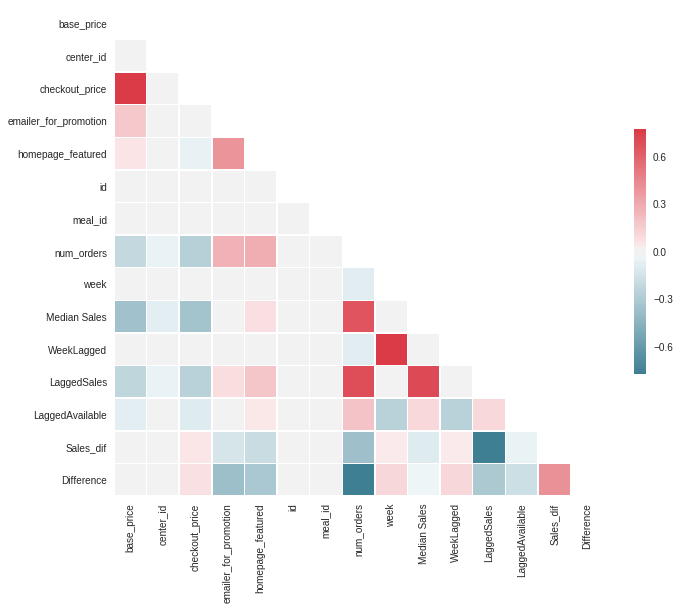

In [22]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
selector = [
    'base_price',
    'checkout_price',
    'emailer_for_promotion',
    'homepage_featured',
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,base_price,checkout_price,emailer_for_promotion,homepage_featured,LaggedSales,Sales_dif,LaggedAvailable
count,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000
mean,354.312259,332.879277,0.080172,0.107346,258.928723,-40.151453,0.888371
std,160.352168,153.022073,0.271560,0.309552,387.799743,276.131497,0.314910
min,55.350000,2.970000,0.000000,0.000000,13.000000,-22908.000000,0.000000
25%,243.500000,228.010000,0.000000,0.000000,54.000000,-41.500000,1.000000
50%,311.430000,299.760000,0.000000,0.000000,136.000000,0.000000,1.000000
75%,458.810000,445.230000,0.000000,0.000000,323.000000,28.000000,1.000000
max,1112.620000,1113.620000,1.000000,1.000000,24299.000000,1552.000000,1.000000


,base_price,checkout_price,emailer_for_promotion,homepage_featured,LaggedSales,Sales_dif,LaggedAvailable
0,152.29,136.83,0,0,215.0,0.0,0.0
1,152.29,135.83,0,0,177.0,38.0,1.0
2,133.92,132.92,0,0,323.0,-108.0,1.0
3,134.86,135.86,0,0,96.0,119.0,1.0
4,147.50,146.50,0,0,163.0,52.0,1.0


In [24]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
test.head()

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,Median Sales,Key,WeekLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
145,Test,159.11,55,158.11,0,0,1028232,1885,0.0,146,215.0,188555,145,121.0,1.0,94.0,215.0
146,Test,159.11,55,159.11,0,0,1262649,1885,0.0,147,215.0,188555,146,215.0,0.0,0.0,215.0
147,Test,158.14,55,157.14,0,0,1453211,1885,0.0,149,215.0,188555,148,215.0,0.0,0.0,215.0
148,Test,157.14,55,159.14,0,0,1262599,1885,0.0,150,215.0,188555,149,215.0,0.0,0.0,215.0
149,Test,159.11,55,160.11,0,0,1495848,1885,0.0,151,215.0,188555,150,215.0,0.0,0.0,215.0


In [33]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(91310, 7)
(91310,)


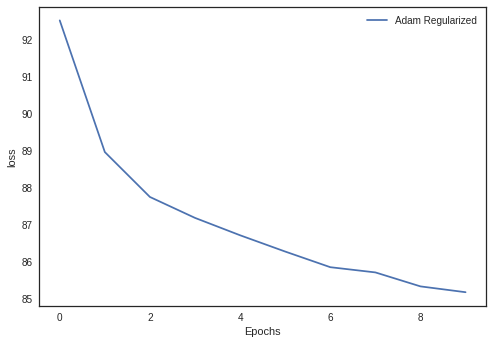

In [42]:
adam_regularized = Sequential()

# First hidden layer now regularized
adam_regularized.add(Dense(32,activation='relu',
                input_dim=X_train.shape[1],
                kernel_regularizer = regularizers.l2(0.01)))

# Second hidden layer now regularized
adam_regularized.add(Dense(16,activation='relu',
                   kernel_regularizer = regularizers.l2(0.01)))

# Output layer stayed sigmoid
adam_regularized.add(Dense(1,activation='linear'))

# Setup adam optimizer
adam_optimizer=keras.optimizers.Adam(lr=0.01,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
adam_regularized.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['acc'])

# Train
history_adam_regularized=adam_regularized.fit(train[selector], train['Difference'], # Train on training set
                             epochs=10, # We will train over 1,000 epochs
                             batch_size=2048, # Batch size 
                             verbose=0) # Suppress Keras output
#adam_regularized.evaluate(x=X_dev,y=y_dev)

# Plot network
plt.plot(history_adam_regularized.history['loss'], label='Adam Regularized')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
y_pred_neural = adam_regularized.predict(test[selector])

In [0]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()

In [0]:
final_y_prediction = y_pred_neural

In [44]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,Split,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,Median Sales,Key,WeekLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,Test,159.11,55,158.11,0,0,1028232,1885,0.0,146,215.0,188555,145,121.0,1.0,94.0,215.0,42.759979,172.240021
1,Test,159.11,55,159.11,0,0,1262649,1885,0.0,147,215.0,188555,146,215.0,0.0,0.0,215.0,5.134980,209.865020
2,Test,158.14,55,157.14,0,0,1453211,1885,0.0,149,215.0,188555,148,215.0,0.0,0.0,215.0,4.898488,210.101512
3,Test,157.14,55,159.14,0,0,1262599,1885,0.0,150,215.0,188555,149,215.0,0.0,0.0,215.0,5.530869,209.469131
4,Test,159.11,55,160.11,0,0,1495848,1885,0.0,151,215.0,188555,150,215.0,0.0,0.0,215.0,5.352346,209.647654


In [47]:
submission = pd.DataFrame({'key' : range(len(test)),'num_orders':testfile['prediction']})
submission.head()

,key,num_orders
0,0,172.240021
1,1,209.865020
2,2,210.101512
3,3,209.469131
4,4,209.647654


In [48]:
sno = pd.DataFrame({'key' : range(len(test)),'id':test['id']})
submission = pd.merge(sno, submission)
submission.drop(['key'], axis = 1, inplace= True)
submission.head()

,id,num_orders
0,1028232,172.240021
1,1262649,209.865020
2,1453211,210.101512
3,1262599,209.469131
4,1495848,209.647654


In [0]:
submission.to_csv('submission_2.csv', index= False)

In [0]:
from google.colab import files
files.download('submission_2.csv')